# Word Embeddings: Ungraded Practice Notebook

In this ungraded notebook, you'll try out all the individual techniques that you learned about in the lecture. Practicing on small examples will prepare you for the graded assignment, where you will combine the techniques in more advanced ways to create word embeddings from a real-life corpus.

This notebook is made of two main parts: data preparation, and the continuous bag-of-words (CBOW) model.

To get started, import and initialize all the libraries you will need.

In [1]:
# change directory to colab
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/MyDrive/NLP/GitHub/C2_Probabilistic_Models/04_Word_Embeddings

Mounted at /gdrive
/gdrive/MyDrive/NLP/GitHub/C2_Probabilistic_Models/04_Word_Embeddings


In [2]:
import sys
!{sys.executable} -m pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=f9584a3ddec99c967cd94e7dd02a010a329755fa84fe7f527c70d55153816e1d
  Stored in directory: /root/.cache/pip/wheels/86/62/9e/a6b27a681abcde69970dbc0326ff51955f3beac72f15696984
Successfully built emoji


In [3]:
import re
import nltk
from nltk.tokenize import word_tokenize
import emoji
import numpy as np

from utils2 import get_dict

nltk.download('punkt')  # download pre-trained Punkt tokenizer for English

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Data preparation

In the data preparation phase, starting with a corpus of text, you will:

- Clean and tokenize the corpus.

- Extract the pairs of context words and center word that will make up the training data set for the CBOW model. The context words are the features that will be fed into the model, and the center words are the target values that the model will learn to predict.

- Create simple vector representations of the context words (features) and center words (targets) that can be used by the neural network of the CBOW model.

## Cleaning and tokenization

To demonstrate the cleaning and tokenization process, consider a corpus that contains emojis and various punctuation signs.

In [4]:
corpus = 'Who ❤️ "word embeddings" in 2020? I do!!!'

First, replace all interrupting punctuation signs — such as commas and exclamation marks — with periods.

In [5]:
print(f'Corpus:  {corpus}')
data = re.sub(r'[,!?;-]+', '.', corpus)
print(f'After cleaning punctuation:  {data}')

Corpus:  Who ❤️ "word embeddings" in 2020? I do!!!
After cleaning punctuation:  Who ❤️ "word embeddings" in 2020. I do.


Next, use NLTK's tokenization engine to split the corpus into individual tokens.

In [6]:
print(f'Initial string:  {data}')
data = nltk.word_tokenize(data)
print(f'After tokenization:  {data}')

Initial string:  Who ❤️ "word embeddings" in 2020. I do.
After tokenization:  ['Who', '❤️', '``', 'word', 'embeddings', "''", 'in', '2020', '.', 'I', 'do', '.']


Finally, as you saw in the lecture, get rid of numbers and punctuation other than periods, and convert all the remaining tokens to lowercase.

In [10]:
print(f'Initial list of tokens:  {data}')
data = [ ch.lower() for ch in data
         if ch.isalpha()
         or ch == '.'
         or emoji.is_emoji(ch)
       ]
print(f'After cleaning:  {data}')

Initial list of tokens:  ['who', 'word', 'embeddings', 'in', '.', 'i', 'do', '.']
After cleaning:  ['who', 'word', 'embeddings', 'in', '.', 'i', 'do', '.']


Note that the heart emoji is considered as a token just like any normal word.

Now let's streamline the cleaning and tokenization process by wrapping the previous steps in a function.

In [14]:
def tokenize(corpus):
    data = re.sub(r'[,!?;-]+', '.', corpus)
    data = nltk.word_tokenize(data)  # tokenize string to words
    data = [ ch.lower() for ch in data
             if ch.isalpha()
             or ch == '.'
             or emoji.is_emoji(ch)
           ]
    return data

Apply this function to the corpus that you'll be working on in the rest of this notebook: "I am happy because I am learning"

In [15]:
corpus = 'I am happy because I am learning'
print(f'Corpus:  {corpus}')
words = tokenize(corpus)
print(f'Words (tokens):  {words}')

Corpus:  I am happy because I am learning
Words (tokens):  ['i', 'am', 'happy', 'because', 'i', 'am', 'learning']


**Now try it out yourself with your own sentence.**

In [16]:
tokenize("Now it's your turn: try with your own sentence!")

['now', 'it', 'your', 'turn', 'try', 'with', 'your', 'own', 'sentence', '.']

## Sliding window of words

Now that you have transformed the corpus into a list of clean tokens, you can slide a window of words across this list. For each window you can extract a center word and the context words.

The `get_windows` function in the next cell was introduced in the lecture.

In [17]:
def get_windows(words, C):
    i = C
    while i < len(words) - C:
        center_word = words[i]
        context_words = words[(i - C):i] + words[(i+1):(i+C+1)]
        yield context_words, center_word
        i += 1

The first argument of this function is a list of words (or tokens). The second argument, `C`, is the context half-size. Recall that for a given center word, the context words are made of `C` words to the left and `C` words to the right of the center word.

Here is how you can use this function to extract context words and center words from a list of tokens. These context and center words will make up the training set that you will use to train the CBOW model.

In [18]:
for x, y in get_windows(
            ['i', 'am', 'happy', 'because', 'i', 'am', 'learning'],
            2
        ):
    print(f'{x}\t{y}')

['i', 'am', 'because', 'i']	happy
['am', 'happy', 'i', 'am']	because
['happy', 'because', 'am', 'learning']	i


The first example of the training set is made of:

- the context words "i", "am", "because", "i",

- and the center word to be predicted: "happy".

**Now try it out yourself. In the next cell, you can change both the sentence and the context half-size.**

In [19]:
for x, y in get_windows(tokenize("Now it's your turn: try with your own sentence!"), 1):
    print(f'{x}\t{y}')

['now', 'your']	it
['it', 'turn']	your
['your', 'try']	turn
['turn', 'with']	try
['try', 'your']	with
['with', 'own']	your
['your', 'sentence']	own
['own', '.']	sentence


## Transforming words into vectors for the training set

To finish preparing the training set, you need to transform the context words and center words into vectors.

### Mapping words to indices and indices to words

The center words will be represented as one-hot vectors, and the vectors that represent context words are also based on one-hot vectors.

To create one-hot word vectors, you can start by mapping each unique word to a unique integer (or index). We have provided a helper function, `get_dict`, that creates a Python dictionary that maps words to integers and back.

In [20]:
word2Ind, Ind2word = get_dict(words)

Here's the dictionary that maps words to numeric indices.

In [21]:
word2Ind

{'am': 0, 'because': 1, 'happy': 2, 'i': 3, 'learning': 4}

You can use this dictionary to get the index of a word.

In [22]:
print("Index of the word 'i':  ",word2Ind['i'])

Index of the word 'i':   3


And conversely, here's the dictionary that maps indices to words.

In [23]:
Ind2word

{0: 'am', 1: 'because', 2: 'happy', 3: 'i', 4: 'learning'}

In [24]:
print("Word which has index 2:  ",Ind2word[2] )

Word which has index 2:   happy


Finally, get the length of either of these dictionaries to get the size of the vocabulary of your corpus, in other words the number of different words making up the corpus.

In [25]:
V = len(word2Ind)
print("Size of vocabulary: ", V)

Size of vocabulary:  5


### Getting one-hot word vectors

Recall from the lecture that you can easily convert an integer, $n$, into a one-hot vector.

Consider the word "happy". First, retrieve its numeric index.

In [26]:
n = word2Ind['happy']
n

2

Now create a vector with the size of the vocabulary, and fill it with zeros.

In [27]:
center_word_vector = np.zeros(V)
center_word_vector

array([0., 0., 0., 0., 0.])

You can confirm that the vector has the right size.

In [28]:
len(center_word_vector) == V

True

Next, replace the 0 of the $n$-th element with a 1.

In [29]:
center_word_vector[n] = 1

And you have your one-hot word vector.

In [30]:
center_word_vector

array([0., 0., 1., 0., 0.])

**You can now group all of these steps in a convenient function, which takes as parameters: a word to be encoded, a dictionary that maps words to indices, and the size of the vocabulary.**

In [31]:
def word_to_one_hot_vector(word, word2Ind, V):
    one_hot_vector = np.zeros(V)
    one_hot_vector[word2Ind[word]] = 1
    
    return one_hot_vector

Check that it works as intended.

In [32]:
word_to_one_hot_vector('happy', word2Ind, V)

array([0., 0., 1., 0., 0.])

**What is the word vector for "learning"?**

In [33]:
word_to_one_hot_vector('learning', word2Ind, V)

array([0., 0., 0., 0., 1.])

Expected output:

    array([0., 0., 0., 0., 1.])

### Getting context word vectors

To create the vectors that represent context words, you will calculate the average of the one-hot vectors representing the individual words.

Let's start with a list of context words.

In [34]:
context_words = ['i', 'am', 'because', 'i']

Using Python's list comprehension construct and the `word_to_one_hot_vector` function that you created in the previous section, you can create a list of one-hot vectors representing each of the context words.

In [35]:
context_words_vectors = [word_to_one_hot_vector(w, word2Ind, V) for w in context_words]
context_words_vectors

[array([0., 0., 0., 1., 0.]),
 array([1., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0.]),
 array([0., 0., 0., 1., 0.])]

And you can now simply get the average of these vectors using numpy's `mean` function, to get the vector representation of the context words.

In [36]:
np.mean(context_words_vectors, axis=0)

array([0.25, 0.25, 0.  , 0.5 , 0.  ])

Note the `axis=0` parameter that tells `mean` to calculate the average of the rows (if you had wanted the average of the columns, you would have used `axis=1`).

**Now create the `context_words_to_vector` function that takes in a list of context words, a word-to-index dictionary, and a vocabulary size, and outputs the vector representation of the context words.**

In [37]:
def context_words_to_vector(context_words, word2Ind, V):
    context_words_vectors = [word_to_one_hot_vector(w, word2Ind, V) for w in context_words]
    context_words_vectors = np.mean(context_words_vectors, axis=0)
    
    return context_words_vectors

And check that you obtain the same output as the manual approach above.

In [38]:
context_words_to_vector(['i', 'am', 'because', 'i'], word2Ind, V)

array([0.25, 0.25, 0.  , 0.5 , 0.  ])

**What is the vector representation of the context words "am happy i am"?**

In [39]:
context_words_to_vector(['am', 'happy', 'i', 'am'], word2Ind, V)

array([0.5 , 0.  , 0.25, 0.25, 0.  ])

Expected output:

    array([0.5 , 0.  , 0.25, 0.25, 0.  ])


## Building the training set

You can now combine the functions that you created in the previous sections, to build a training set for the CBOW model, starting from the following tokenized corpus.

In [40]:
words

['i', 'am', 'happy', 'because', 'i', 'am', 'learning']

To do this you need to use the sliding window function (`get_windows`) to extract the context words and center words, and you then convert these sets of words into a basic vector representation using `word_to_one_hot_vector` and `context_words_to_vector`.

In [41]:
for context_words, center_word in get_windows(words, 2):  # reminder: 2 is the context half-size
    print(f'Context words:  {context_words} -> {context_words_to_vector(context_words, word2Ind, V)}')
    print(f'Center word:  {center_word} -> {word_to_one_hot_vector(center_word, word2Ind, V)}')
    print()

Context words:  ['i', 'am', 'because', 'i'] -> [0.25 0.25 0.   0.5  0.  ]
Center word:  happy -> [0. 0. 1. 0. 0.]

Context words:  ['am', 'happy', 'i', 'am'] -> [0.5  0.   0.25 0.25 0.  ]
Center word:  because -> [0. 1. 0. 0. 0.]

Context words:  ['happy', 'because', 'am', 'learning'] -> [0.25 0.25 0.25 0.   0.25]
Center word:  i -> [0. 0. 0. 1. 0.]



In this practice notebook you'll be performing a single iteration of training using a single example, but in this week's assignment you'll train the CBOW model using several iterations and batches of example.
Here is how you would use a Python generator function (remember the `yield` keyword from the lecture?) to make it easier to iterate over a set of examples.

In [42]:
def get_training_example(words, C, word2Ind, V):
    for context_words, center_word in get_windows(words, C):
        yield context_words_to_vector(context_words, word2Ind, V), word_to_one_hot_vector(center_word, word2Ind, V)

The output of this function can be iterated on to get successive context word vectors and center word vectors, as demonstrated in the next cell.

In [43]:
for context_words_vector, center_word_vector in get_training_example(words, 2, word2Ind, V):
    print(f'Context words vector:  {context_words_vector}')
    print(f'Center word vector:  {center_word_vector}')
    print()

Context words vector:  [0.25 0.25 0.   0.5  0.  ]
Center word vector:  [0. 0. 1. 0. 0.]

Context words vector:  [0.5  0.   0.25 0.25 0.  ]
Center word vector:  [0. 1. 0. 0. 0.]

Context words vector:  [0.25 0.25 0.25 0.   0.25]
Center word vector:  [0. 0. 0. 1. 0.]



Your training set is ready, you can now move on to the CBOW model itself.

# The continuous bag-of-words model

The CBOW model is based on a neural network, the architecture of which looks like the figure below, as you'll recall from the lecture.

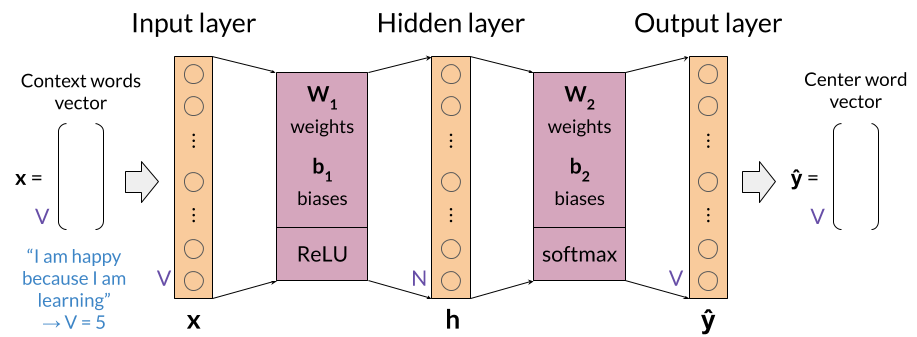

This part of the notebook will walk you through:

- The two activation functions used in the neural network.

- Forward propagation.

- Cross-entropy loss.

- Backpropagation.

- Gradient descent.

- Extracting the word embedding vectors from the weight matrices once the neural network has been trained.

## Activation functions

Let's start by implementing the activation functions, ReLU and softmax.

### ReLU

ReLU is used to calculate the values of the hidden layer, in the following formulas:

\begin{align}
 \mathbf{z_1} &= \mathbf{W_1}\mathbf{x} + \mathbf{b_1}  \tag{1} \\
 \mathbf{h} &= \mathrm{ReLU}(\mathbf{z_1})  \tag{2} \\
\end{align}


Let's fix a value for $\mathbf{z_1}$ as a working example.

In [44]:
np.random.seed(10)
z_1 = 10*np.random.rand(5, 1)-5
z_1

array([[ 2.71320643],
       [-4.79248051],
       [ 1.33648235],
       [ 2.48803883],
       [-0.01492988]])

To get the ReLU of this vector, you want all the negative values to become zeros.

First create a copy of this vector.

In [45]:
h = z_1.copy()

Now determine which of its values are negative.

In [46]:
h < 0

array([[False],
       [ True],
       [False],
       [False],
       [ True]])

You can now simply set all of the values which are negative to 0.

In [47]:
h[h < 0] = 0

And that's it: you have the ReLU of $\mathbf{z_1}$!

In [48]:
h

array([[2.71320643],
       [0.        ],
       [1.33648235],
       [2.48803883],
       [0.        ]])

**Now implement ReLU as a function.**

In [49]:
def relu(z):
    result = z.copy()
    result[result < 0] = 0
    
    return result

**And check that it's working.**

In [50]:
z = np.array([[-1.25459881], [ 4.50714306], [ 2.31993942], [ 0.98658484], [-3.4398136 ]])
relu(z)

array([[0.        ],
       [4.50714306],
       [2.31993942],
       [0.98658484],
       [0.        ]])

Expected output:

    array([[0.        ],
           [4.50714306],
           [2.31993942],
           [0.98658484],
           [0.        ]])

### Softmax

The second activation function that you need is softmax. This function is used to calculate the values of the output layer of the neural network, using the following formulas:

\begin{align}
 \mathbf{z_2} &= \mathbf{W_2}\mathbf{h} + \mathbf{b_2}   \tag{3} \\
 \mathbf{\hat y} &= \mathrm{softmax}(\mathbf{z_2})   \tag{4} \\
\end{align}

To calculate softmax of a vector $\mathbf{z}$, the $i$-th component of the resulting vector is given by:

$$ \textrm{softmax}(\textbf{z})_i = \frac{e^{z_i} }{\sum\limits_{j=1}^{V} e^{z_j} }  \tag{5} $$

Let's work through an example.

In [51]:
z = np.array([9, 8, 11, 10, 8.5])
z

array([ 9. ,  8. , 11. , 10. ,  8.5])

You'll need to calculate the exponentials of each element, both for the numerator and for the denominator.

In [52]:
e_z = np.exp(z)
e_z

array([ 8103.08392758,  2980.95798704, 59874.1417152 , 22026.46579481,
        4914.7688403 ])

The denominator is equal to the sum of these exponentials.

In [53]:
sum_e_z = np.sum(e_z)
sum_e_z

97899.41826492078

And the value of the first element of $\textrm{softmax}(\textbf{z})$ is given by:

In [54]:
e_z[0]/sum_e_z

0.08276947985173956

This is for one element. You can use numpy's vectorized operations to calculate the values of all the elements of the $\textrm{softmax}(\textbf{z})$ vector in one go.

**Implement the softmax function.**

In [55]:
def softmax(z):
    e_z = np.exp(z)
    sum_e_z = np.sum(e_z)
    
    return e_z / sum_e_z

**Now check that it works.**

In [56]:
softmax([9, 8, 11, 10, 8.5])

array([0.08276948, 0.03044919, 0.61158833, 0.22499077, 0.05020223])

Expected output:

    array([0.08276948, 0.03044919, 0.61158833, 0.22499077, 0.05020223])

## Dimensions: 1-D arrays vs 2-D column vectors

Before moving on to implement forward propagation, backpropagation, and gradient descent, let's have a look at the dimensions of the vectors you've been handling until now.

Create a vector of length $V$ filled with zeros.

In [57]:
x_array = np.zeros(V)
x_array

array([0., 0., 0., 0., 0.])

This is a 1-dimensional array, as revealed by the `.shape` property of the array.

In [58]:
x_array.shape

(5,)

To perform matrix multiplication in the next steps, you actually need your column vectors to be represented as a matrix with one column. In numpy, this matrix is represented as a 2-dimensional array.

The easiest way to convert a 1D vector to a 2D column matrix is to set its `.shape` property to the number of rows and one column, as shown in the next cell.

In [59]:
x_column_vector = x_array.copy()
x_column_vector.shape = (V, 1)  # alternatively ... = (x_array.shape[0], 1)
x_column_vector

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])

The shape of the resulting "vector" is:

In [60]:
x_column_vector.shape

(5, 1)

So you now have a 5x1 matrix that you can use to perform standard matrix multiplication.

## Forward propagation

Let's dive into the neural network itself, which is shown below with all the dimensions and formulas you'll need.

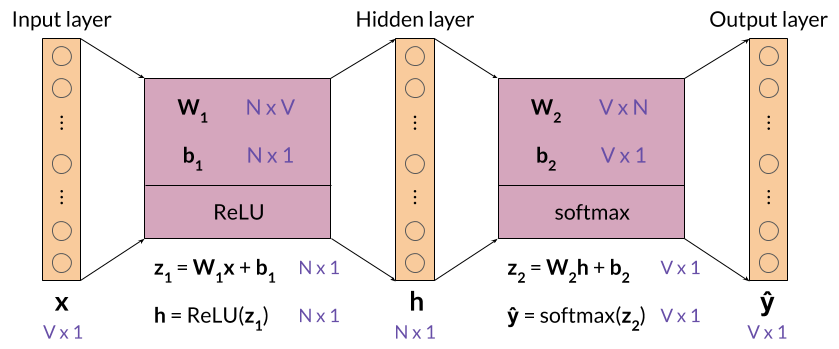

Set $N$ equal to 3. Remember that $N$ is a hyperparameter of the CBOW model that represents the size of the word embedding vectors, as well as the size of the hidden layer.

In [61]:
N = 3

### Initialization of the weights and biases

Before you start training the neural network, you need to initialize the weight matrices and bias vectors with random values.

In the assignment you will implement a function to do this yourself using `numpy.random.rand`. In this notebook, we've pre-populated these matrices and vectors for you.

In [62]:
W1 = np.array([[ 0.41687358,  0.08854191, -0.23495225,  0.28320538,  0.41800106],
               [ 0.32735501,  0.22795148, -0.23951958,  0.4117634 , -0.23924344],
               [ 0.26637602, -0.23846886, -0.37770863, -0.11399446,  0.34008124]])

W2 = np.array([[-0.22182064, -0.43008631,  0.13310965],
               [ 0.08476603,  0.08123194,  0.1772054 ],
               [ 0.1871551 , -0.06107263, -0.1790735 ],
               [ 0.07055222, -0.02015138,  0.36107434],
               [ 0.33480474, -0.39423389, -0.43959196]])

b1 = np.array([[ 0.09688219],
               [ 0.29239497],
               [-0.27364426]])

b2 = np.array([[ 0.0352008 ],
               [-0.36393384],
               [-0.12775555],
               [-0.34802326],
               [-0.07017815]])

**Check that the dimensions of these matrices match those shown in the figure above.**

In [63]:
print(f'V (vocabulary size): {V}')
print(f'N (embedding size / size of the hidden layer): {N}')
print(f'size of W1: {W1.shape} (NxV)')
print(f'size of b1: {b1.shape} (Nx1)')
print(f'size of W2: {W2.shape} (VxN)')
print(f'size of b2: {b2.shape} (Vx1)')

V (vocabulary size): 5
N (embedding size / size of the hidden layer): 3
size of W1: (3, 5) (NxV)
size of b1: (3, 1) (Nx1)
size of W2: (5, 3) (VxN)
size of b2: (5, 1) (Vx1)


### Training example

Run the next cells to get the first training example, made of the vector representing the context words "i am because i", and the target which is the one-hot vector representing the center word "happy".

> You don't need to worry about the Python syntax, but there are some explanations below if you want to know what's happening behind the scenes.

In [64]:
training_examples = get_training_example(words, 2, word2Ind, V)

> `get_training_examples`, which uses the `yield` keyword, is known as a generator. When run, it builds an iterator, which is a special type of object that... you can iterate on (using a `for` loop for instance), to retrieve the successive values that the function generates.
>
> In this case `get_training_examples` `yield`s training examples, and iterating on `training_examples` will return the successive training examples.

In [65]:
x_array, y_array = next(training_examples)

> `next` is another special keyword, which gets the next available value from an iterator. Here, you'll get the very first value, which is the first training example. If you run this cell again, you'll get the next value, and so on until the iterator runs out of values to return.
>
> In this notebook `next` is used because you will only be performing one iteration of training. In this week's assignment with the full training over several iterations you'll use regular `for` loops with the iterator that supplies the training examples.

The vector representing the context words, which will be fed into the neural network, is:

In [66]:
x_array

array([0.25, 0.25, 0.  , 0.5 , 0.  ])

The one-hot vector representing the center word to be predicted is:

In [67]:
y_array

array([0., 0., 1., 0., 0.])

Now convert these vectors into matrices (or 2D arrays) to be able to perform matrix multiplication on the right types of objects, as explained above.

In [68]:
x = x_array.copy()
x.shape = (V, 1)
print('x')
print(x)
print()

y = y_array.copy()
y.shape = (V, 1)
print('y')
print(y)

x
[[0.25]
 [0.25]
 [0.  ]
 [0.5 ]
 [0.  ]]

y
[[0.]
 [0.]
 [1.]
 [0.]
 [0.]]


### Values of the hidden layer

Now that you have initialized all the variables that you need for forward propagation, you can calculate the values of the hidden layer using the following formulas:

\begin{align}
 \mathbf{z_1} = \mathbf{W_1}\mathbf{x} + \mathbf{b_1}  \tag{1} \\
 \mathbf{h} = \mathrm{ReLU}(\mathbf{z_1})  \tag{2} \\
\end{align}

First, you can calculate the value of $\mathbf{z_1}$.

In [69]:
z1 = np.dot(W1, x) + b1

> `np.dot` is numpy's function for matrix multiplication.

As expected you get an $N$ by 1 matrix, or column vector with $N$ elements, where $N$ is equal to the embedding size, which is 3 in this example.

In [70]:
z1

array([[ 0.36483875],
       [ 0.63710329],
       [-0.3236647 ]])

You can now take the ReLU of $\mathbf{z_1}$ to get $\mathbf{h}$, the vector with the values of the hidden layer.

In [71]:
h = relu(z1)
h

array([[0.36483875],
       [0.63710329],
       [0.        ]])

Applying ReLU means that the negative element of $\mathbf{z_1}$ has been replaced with a zero.

### Values of the output layer

Here are the formulas you need to calculate the values of the output layer, represented by the vector $\mathbf{\hat y}$:

\begin{align}
 \mathbf{z_2} &= \mathbf{W_2}\mathbf{h} + \mathbf{b_2}   \tag{3} \\
 \mathbf{\hat y} &= \mathrm{softmax}(\mathbf{z_2})   \tag{4} \\
\end{align}

**First, calculate $\mathbf{z_2}$.**

In [72]:
z2 = np.dot(W2, h) + b2

z2

array([[-0.31973737],
       [-0.28125477],
       [-0.09838369],
       [-0.33512159],
       [-0.19919612]])

Expected output:

    array([[-0.31973737],
           [-0.28125477],
           [-0.09838369],
           [-0.33512159],
           [-0.19919612]])

This is a $V$ by 1 matrix, where $V$ is the size of the vocabulary, which is 5 in this example.

**Now calculate the value of $\mathbf{\hat y}$.**

In [73]:
y_hat = softmax(z2)

y_hat

array([[0.18519074],
       [0.19245626],
       [0.23107446],
       [0.18236353],
       [0.20891502]])

Expected output:

    array([[0.18519074],
           [0.19245626],
           [0.23107446],
           [0.18236353],
           [0.20891502]])

As you've performed the calculations with random matrices and vectors (apart from the input vector), the output of the neural network is essentially random at this point. The learning process will adjust the weights and biases to match the actual targets better.

**That being said, what word did the neural network predict?**

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Solution</b></font>
</summary>
<p>The neural network predicted the word "happy": the largest element of $\mathbf{\hat y}$ is the third one, and the third word of the vocabulary is "happy".</p>
<p>Here's how you could implement this in Python:</p>
<p><code>print(Ind2word[np.argmax(y_hat)])</code></p>

Well done, you've completed the forward propagation phase!

## Cross-entropy loss

Now that you have the network's prediction, you can calculate the cross-entropy loss to determine how accurate the prediction was compared to the actual target.

> Remember that you are working on a single training example, not on a batch of examples, which is why you are using *loss* and not *cost*, which is the generalized form of loss.

First let's recall what the prediction was.

In [74]:
y_hat

array([[0.18519074],
       [0.19245626],
       [0.23107446],
       [0.18236353],
       [0.20891502]])

And the actual target value is:

In [75]:
y

array([[0.],
       [0.],
       [1.],
       [0.],
       [0.]])

The formula for cross-entropy loss is:

$$ J=-\sum\limits_{k=1}^{V}y_k\log{\hat{y}_k} \tag{6}$$

**Implement the cross-entropy loss function.**

Here are a some hints if you're stuck.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hint 1</b></font>
</summary>
    <p>To multiply two numpy matrices (such as <code>y</code> and <code>y_hat</code>) element-wise, you can simply use the <code>*</code> operator.</p>

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hint 2</b></font>
</summary>
<p>Once you have a vector equal to the element-wise multiplication of <code>y</code> and <code>y_hat</code>, you can use <code>np.sum</code> to calculate the sum of the elements of this vector.</p>

In [76]:
def cross_entropy_loss(y_predicted, y_actual):
    loss = np.sum(-np.log(y_predicted)*y_actual)
    
    return loss

**Now use this function to calculate the loss with the actual values of $\mathbf{y}$ and $\mathbf{\hat y}$.**

In [77]:
cross_entropy_loss(y_hat, y)

1.4650152923611106

Expected output:

    1.4650152923611106

This value is neither good nor bad, which is expected as the neural network hasn't learned anything yet.

The actual learning will start during the next phase: backpropagation.

## Backpropagation

The formulas that you will implement for backpropagation are the following.

\begin{align}
 \frac{\partial J}{\partial \mathbf{W_1}} &= \rm{ReLU}\left ( \mathbf{W_2^\top} (\mathbf{\hat{y}} - \mathbf{y})\right )\mathbf{x}^\top \tag{7}\\
 \frac{\partial J}{\partial \mathbf{W_2}} &= (\mathbf{\hat{y}} - \mathbf{y})\mathbf{h^\top} \tag{8}\\
 \frac{\partial J}{\partial \mathbf{b_1}} &= \rm{ReLU}\left ( \mathbf{W_2^\top} (\mathbf{\hat{y}} - \mathbf{y})\right ) \tag{9}\\
 \frac{\partial J}{\partial \mathbf{b_2}} &= \mathbf{\hat{y}} - \mathbf{y} \tag{10}
\end{align}

> Note: these formulas are slightly simplified compared to the ones in the lecture as you're working on a single training example, whereas the lecture provided the formulas for a batch of examples. In the assignment you'll be implementing the latter.

Let's start with an easy one.

**Calculate the partial derivative of the loss function with respect to $\mathbf{b_2}$, and store the result in `grad_b2`.**

$$\frac{\partial J}{\partial \mathbf{b_2}} = \mathbf{\hat{y}} - \mathbf{y} \tag{10}$$

In [78]:
grad_b2 = y_hat - y

grad_b2

array([[ 0.18519074],
       [ 0.19245626],
       [-0.76892554],
       [ 0.18236353],
       [ 0.20891502]])

Expected output:

    array([[ 0.18519074],
           [ 0.19245626],
           [-0.76892554],
           [ 0.18236353],
           [ 0.20891502]])

**Next, calculate the partial derivative of the loss function with respect to $\mathbf{W_2}$, and store the result in `grad_W2`.**

$$\frac{\partial J}{\partial \mathbf{W_2}} = (\mathbf{\hat{y}} - \mathbf{y})\mathbf{h^\top} \tag{8}$$

> Hint: use `.T` to get a transposed matrix, e.g. `h.T` returns $\mathbf{h^\top}$.

In [79]:
grad_W2 = np.dot(y_hat - y, h.T)

grad_W2

array([[ 0.06756476,  0.11798563,  0.        ],
       [ 0.0702155 ,  0.12261452,  0.        ],
       [-0.28053384, -0.48988499,  0.        ],
       [ 0.06653328,  0.1161844 ,  0.        ],
       [ 0.07622029,  0.13310045,  0.        ]])

Expected output:

    array([[ 0.06756476,  0.11798563,  0.        ],
           [ 0.0702155 ,  0.12261452,  0.        ],
           [-0.28053384, -0.48988499,  0.        ],
           [ 0.06653328,  0.1161844 ,  0.        ],
           [ 0.07622029,  0.13310045,  0.        ]])

**Now calculate the partial derivative with respect to $\mathbf{b_1}$ and store the result in `grad_b1`.**

$$\frac{\partial J}{\partial \mathbf{b_1}} = \rm{ReLU}\left ( \mathbf{W_2^\top} (\mathbf{\hat{y}} - \mathbf{y})\right ) \tag{9}$$

In [80]:
grad_b1 = relu(np.dot(W2.T, y_hat - y))

grad_b1

array([[0.        ],
       [0.        ],
       [0.17045858]])

Expected output:

    array([[0.        ],
           [0.        ],
           [0.17045858]])

**Finally, calculate the partial derivative of the loss with respect to $\mathbf{W_1}$, and store it in `grad_W1`.**

$$\frac{\partial J}{\partial \mathbf{W_1}} = \rm{ReLU}\left ( \mathbf{W_2^\top} (\mathbf{\hat{y}} - \mathbf{y})\right )\mathbf{x}^\top \tag{7}$$

In [81]:
grad_W1 = np.dot(relu(np.dot(W2.T, y_hat - y)), x.T)

grad_W1

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.04261464, 0.04261464, 0.        , 0.08522929, 0.        ]])

Expected output:

    array([[0.        , 0.        , 0.        , 0.        , 0.        ],
           [0.        , 0.        , 0.        , 0.        , 0.        ],
           [0.04261464, 0.04261464, 0.        , 0.08522929, 0.        ]])

Before moving on to gradient descent, double-check that all the matrices have the expected dimensions.

In [82]:
print(f'V (vocabulary size): {V}')
print(f'N (embedding size / size of the hidden layer): {N}')
print(f'size of grad_W1: {grad_W1.shape} (NxV)')
print(f'size of grad_b1: {grad_b1.shape} (Nx1)')
print(f'size of grad_W2: {grad_W2.shape} (VxN)')
print(f'size of grad_b2: {grad_b2.shape} (Vx1)')

V (vocabulary size): 5
N (embedding size / size of the hidden layer): 3
size of grad_W1: (3, 5) (NxV)
size of grad_b1: (3, 1) (Nx1)
size of grad_W2: (5, 3) (VxN)
size of grad_b2: (5, 1) (Vx1)


## Gradient descent

During the gradient descent phase, you will update the weights and biases by subtracting $\alpha$ times the gradient from the original matrices and vectors, using the following formulas.

\begin{align}
 \mathbf{W_1} &:= \mathbf{W_1} - \alpha \frac{\partial J}{\partial \mathbf{W_1}} \tag{11}\\
 \mathbf{W_2} &:= \mathbf{W_2} - \alpha \frac{\partial J}{\partial \mathbf{W_2}} \tag{12}\\
 \mathbf{b_1} &:= \mathbf{b_1} - \alpha \frac{\partial J}{\partial \mathbf{b_1}} \tag{13}\\
 \mathbf{b_2} &:= \mathbf{b_2} - \alpha \frac{\partial J}{\partial \mathbf{b_2}} \tag{14}\\
\end{align}

First, let set a value for $\alpha$.

In [83]:
alpha = 0.03

The updated weight matrix $\mathbf{W_1}$ will be:

In [84]:
W1_new = W1 - alpha * grad_W1

Let's compare the previous and new values of $\mathbf{W_1}$:

In [85]:
print('old value of W1:')
print(W1)
print()
print('new value of W1:')
print(W1_new)

old value of W1:
[[ 0.41687358  0.08854191 -0.23495225  0.28320538  0.41800106]
 [ 0.32735501  0.22795148 -0.23951958  0.4117634  -0.23924344]
 [ 0.26637602 -0.23846886 -0.37770863 -0.11399446  0.34008124]]

new value of W1:
[[ 0.41687358  0.08854191 -0.23495225  0.28320538  0.41800106]
 [ 0.32735501  0.22795148 -0.23951958  0.4117634  -0.23924344]
 [ 0.26509758 -0.2397473  -0.37770863 -0.11655134  0.34008124]]


The difference is very subtle (hint: take a closer look at the last row), which is why it takes a fair amount of iterations to train the neural network until it reaches optimal weights and biases starting from random values.

**Now calculate the new values of $\mathbf{W_2}$ (to be stored in `W2_new`), $\mathbf{b_1}$ (in `b1_new`), and $\mathbf{b_2}$ (in `b2_new`).**

\begin{align}
 \mathbf{W_2} &:= \mathbf{W_2} - \alpha \frac{\partial J}{\partial \mathbf{W_2}} \tag{12}\\
 \mathbf{b_1} &:= \mathbf{b_1} - \alpha \frac{\partial J}{\partial \mathbf{b_1}} \tag{13}\\
 \mathbf{b_2} &:= \mathbf{b_2} - \alpha \frac{\partial J}{\partial \mathbf{b_2}} \tag{14}\\
\end{align}

In [86]:
W2_new = W2 - alpha * grad_W2
b1_new = b1 - alpha * grad_b1
b2_new = b2 - alpha * grad_b2

print('W2_new')
print(W2_new)
print()
print('b1_new')
print(b1_new)
print()
print('b2_new')
print(b2_new)

W2_new
[[-0.22384758 -0.43362588  0.13310965]
 [ 0.08265956  0.0775535   0.1772054 ]
 [ 0.19557112 -0.04637608 -0.1790735 ]
 [ 0.06855622 -0.02363691  0.36107434]
 [ 0.33251813 -0.3982269  -0.43959196]]

b1_new
[[ 0.09688219]
 [ 0.29239497]
 [-0.27875802]]

b2_new
[[ 0.02964508]
 [-0.36970753]
 [-0.10468778]
 [-0.35349417]
 [-0.0764456 ]]


Expected output:

    W2_new
    [[-0.22384758 -0.43362588  0.13310965]
     [ 0.08265956  0.0775535   0.1772054 ]
     [ 0.19557112 -0.04637608 -0.1790735 ]
     [ 0.06855622 -0.02363691  0.36107434]
     [ 0.33251813 -0.3982269  -0.43959196]]

    b1_new
    [[ 0.09688219]
     [ 0.29239497]
     [-0.27875802]]

    b2_new
    [[ 0.02964508]
     [-0.36970753]
     [-0.10468778]
     [-0.35349417]
     [-0.0764456 ]]

Congratulations, you have completed one iteration of training using one training example!

You'll need many more iterations to fully train the neural network, and you can optimize the learning process by training on batches of examples, as described in the lecture. You will get to do this during this week's assignment.

## Extracting word embedding vectors

Once you have finished training the neural network, you have three options to get word embedding vectors for the words of your vocabulary, based on the weight matrices $\mathbf{W_1}$ and/or $\mathbf{W_2}$.

### Option 1: extract embedding vectors from $\mathbf{W_1}$

The first option is to take the columns of $\mathbf{W_1}$ as the embedding vectors of the words of the vocabulary, using the same order of the words as for the input and output vectors.

> Note: in this practice notebook the values of the word embedding vectors are meaningless after a single iteration with just one training example, but here's how you would proceed after the training process is complete.

For example $\mathbf{W_1}$ is this matrix:

In [87]:
W1

array([[ 0.41687358,  0.08854191, -0.23495225,  0.28320538,  0.41800106],
       [ 0.32735501,  0.22795148, -0.23951958,  0.4117634 , -0.23924344],
       [ 0.26637602, -0.23846886, -0.37770863, -0.11399446,  0.34008124]])

The first column, which is a 3-element vector, is the embedding vector of the first word of your vocabulary. The second column is the word embedding vector for the second word, and so on.

The first, second, etc. words are ordered as follows.

In [88]:
for i in range(V):
    print(Ind2word[i])

am
because
happy
i
learning


So the word embedding vectors corresponding to each word are:

In [89]:
# loop through each word of the vocabulary
for word in word2Ind:
    # extract the column corresponding to the index of the word in the vocabulary
    word_embedding_vector = W1[:, word2Ind[word]]
    
    print(f'{word}: {word_embedding_vector}')

am: [0.41687358 0.32735501 0.26637602]
because: [ 0.08854191  0.22795148 -0.23846886]
happy: [-0.23495225 -0.23951958 -0.37770863]
i: [ 0.28320538  0.4117634  -0.11399446]
learning: [ 0.41800106 -0.23924344  0.34008124]


### Option 2: extract embedding vectors from $\mathbf{W_2}$

The second option is to take $\mathbf{W_2}$ transposed, and take its columns as the word embedding vectors just like you did for $\mathbf{W_1}$.

In [90]:
W2.T

array([[-0.22182064,  0.08476603,  0.1871551 ,  0.07055222,  0.33480474],
       [-0.43008631,  0.08123194, -0.06107263, -0.02015138, -0.39423389],
       [ 0.13310965,  0.1772054 , -0.1790735 ,  0.36107434, -0.43959196]])

In [91]:
# loop through each word of the vocabulary
for word in word2Ind:
    # extract the column corresponding to the index of the word in the vocabulary
    word_embedding_vector = W2.T[:, word2Ind[word]]
    
    print(f'{word}: {word_embedding_vector}')

am: [-0.22182064 -0.43008631  0.13310965]
because: [0.08476603 0.08123194 0.1772054 ]
happy: [ 0.1871551  -0.06107263 -0.1790735 ]
i: [ 0.07055222 -0.02015138  0.36107434]
learning: [ 0.33480474 -0.39423389 -0.43959196]


### Option 3: extract embedding vectors from $\mathbf{W_1}$ and $\mathbf{W_2}$

The third option, which is the one you will use in this week's assignment, uses the average of $\mathbf{W_1}$ and $\mathbf{W_2^\top}$.

**Calculate the average of $\mathbf{W_1}$ and $\mathbf{W_2^\top}$, and store the result in `W3`.**

In [92]:
W3 = (W1+W2.T)/2

W3

array([[ 0.09752647,  0.08665397, -0.02389858,  0.1768788 ,  0.3764029 ],
       [-0.05136565,  0.15459171, -0.15029611,  0.19580601, -0.31673866],
       [ 0.19974284, -0.03063173, -0.27839106,  0.12353994, -0.04975536]])

Expected output:

    array([[ 0.09752647,  0.08665397, -0.02389858,  0.1768788 ,  0.3764029 ],
           [-0.05136565,  0.15459171, -0.15029611,  0.19580601, -0.31673866],
           [ 0.19974284, -0.03063173, -0.27839106,  0.12353994, -0.04975536]])

Extracting the word embedding vectors works just like the two previous options, by taking the columns of the matrix you've just created.

In [93]:
# loop through each word of the vocabulary
for word in word2Ind:
    # extract the column corresponding to the index of the word in the vocabulary
    word_embedding_vector = W3[:, word2Ind[word]]
    
    print(f'{word}: {word_embedding_vector}')

am: [ 0.09752647 -0.05136565  0.19974284]
because: [ 0.08665397  0.15459171 -0.03063173]
happy: [-0.02389858 -0.15029611 -0.27839106]
i: [0.1768788  0.19580601 0.12353994]
learning: [ 0.3764029  -0.31673866 -0.04975536]


You're now ready to take on this week's assignment!

### How this practice relates to and differs from the upcoming graded assignment

- In the assignment, for each iteration of training you will use batches of examples instead of a single example. The formulas for forward propagation and backpropagation will be modified accordingly, and you will use cross-entropy cost instead of cross-entropy loss.
- You will also complete several iterations of training, until you reach an acceptably low cross-entropy cost, at which point you can extract good word embeddings from the weight matrices.
- After extracting the word embedding vectors, you will use principal component analysis (PCA) to visualize the vectors, which will enable you to perform an intrinsic evaluation of the quality of the vectors, as explained in the lecture.